In [26]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [27]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [48]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, select, and_

In [39]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [40]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(autoload_with=engine)

In [41]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [42]:
# Save references to each table
measurement = Base.classes.measurement

station = Base.classes.station

In [43]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [44]:
#Previewing column names

measurement_firstrow = session.query(measurement).first()


print(measurement_firstrow.__dict__.keys())

dict_keys(['_sa_instance_state', 'prcp', 'id', 'station', 'date', 'tobs'])


In [45]:
#Previewing column names

station_firstrow = session.query(station).first()

print(station_firstrow.__dict__.keys())

dict_keys(['_sa_instance_state', 'longitude', 'station', 'name', 'id', 'latitude', 'elevation'])


In [59]:
# Find the most recent date in the data set.

most_recent_date_str = session.query(func.max(measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d')

#converted dates to datetime and pulled most recent date

print(most_recent_date)

2017-08-23 00:00:00


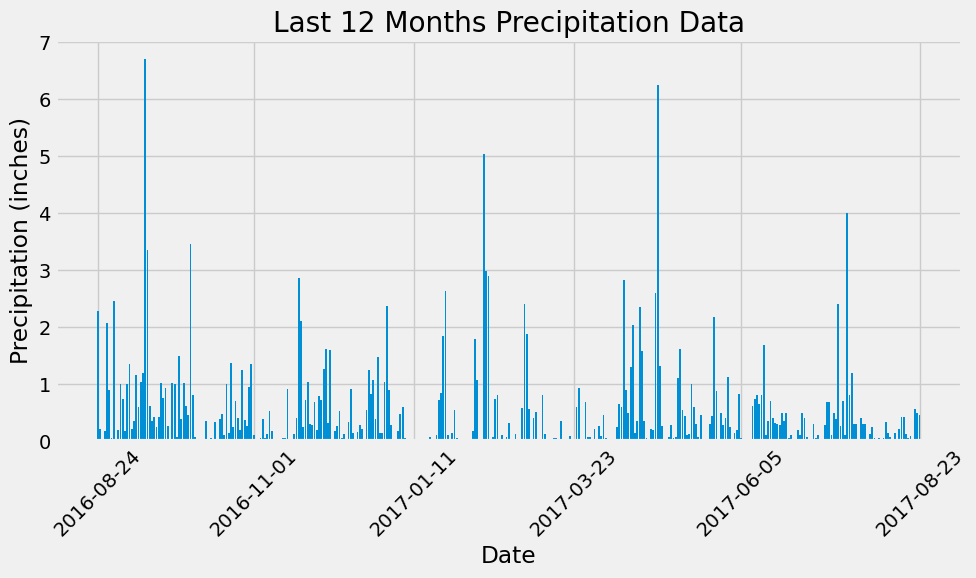

In [61]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

one_year_ago = most_recent_date - timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores

precipitation_data = session.query(measurement.date, measurement.prcp)\
    .filter(and_(measurement.date >= one_year_ago, measurement.date <= most_recent_date))\
    .all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names

prcp_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date

prcp_df.sort_values(by='date', inplace=True)

#converted date column to datetime

prcp_df['date'] = pd.to_datetime(prcp_df['date'])



# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(10, 6))
plt.bar(df['date'], df['precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months Precipitation Data')

# Avoid showing every single date in x axis labels
date_ticks = prcp_df['date'].iloc[::len(df)//5]
plt.xticks(date_ticks, rotation=45)

plt.tight_layout()
plt.show()

In [63]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = prcp_df['precipitation'].describe()

summary_statistics

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [66]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.id)).scalar()

print("Total number of stations:", total_stations)

Total number of stations: 9


In [69]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station).desc())\
    .all()


most_active_stations_list = [(station, count) for station, count in most_active_stations]


for station_info in most_active_stations_list:
    print(station_info)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [71]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = most_active_stations_list[0][0]

# Query to calculate lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs))\
    .filter(measurement.station == most_active_station)\
    .all()

# Extract temperature statistics
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

# Print the temperature statistics as a list of values
temperature_statistics_list = [lowest_temp, highest_temp, avg_temp]

print(temperature_statistics_list)

[54.0, 85.0, 71.66378066378067]


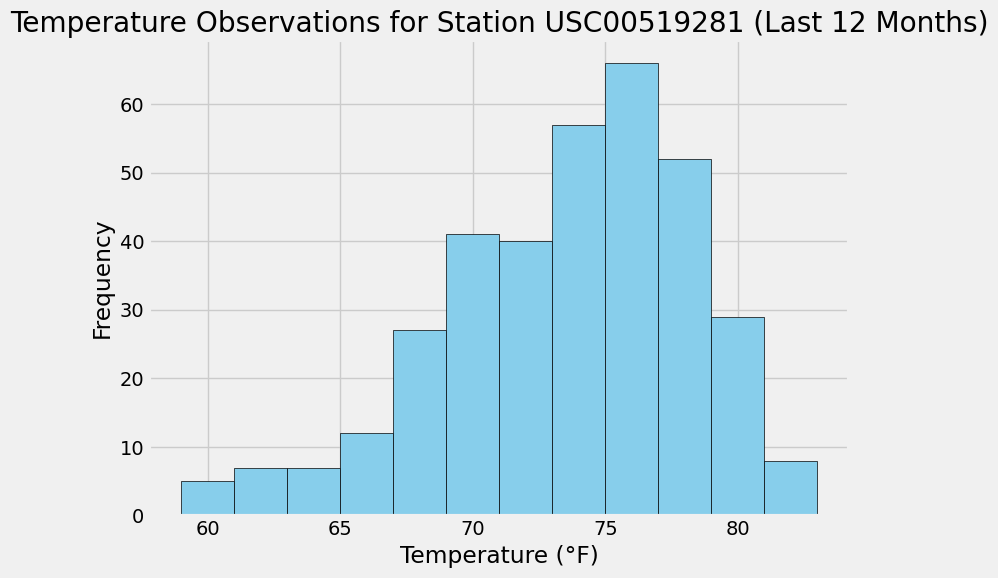

In [73]:
# Using the most active station id

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurement.tobs)\
    .filter(and_(measurement.date >= one_year_ago, measurement.station == most_active_station))\
    .all()

# Converting to DataFrame
df = pd.DataFrame(temperature_data, columns=['temperature'])

# Plotting Histogram
plt.figure(figsize=(8, 6))
plt.hist(df['temperature'], bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station} (Last 12 Months)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Close Session

In [18]:
# Close Session
session.close()